# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 5</span> - <span style="color:red"> Only for master students</span>


In quantum physics a **wave function**, $\Psi$, is a mathematical description of the state of a quantum system. The wave function is a complex-valued probability amplitude, and the probabilities for the possible results of measurements made on the system can be derived from it.

For now on, let's consider the simple case of a non-relativistic single particle, without spin, in three spatial dimensions. The state of such a particle is completely described by its wave function, $\Psi(\vec{r},t)$, where $\vec{r}$ is position and $t$ is time.

For one spinless particle, if the wave function is interpreted as a probability amplitude, the square modulus of the wave function, $|\Psi(\vec{r},t)|^2$, is interpreted as the probability density that the particle is at $\vec{r}$ at time $t$. Once we have a probability density, we can use Monte Carlo ...

#### Hydrogen atom
The wave functions of the eigenstates of an electron in a Hydrogen atom (this is the only atom for which the Schroedinger equation has been solved exactly) are expressed in terms of spherical harmonics and generalized Laguerre polynomials. It is convenient to use spherical coordinates, and the wave function can be separated into functions of each coordinate:

$$
\Psi_{n,l,m}(r,\theta,\phi)=
\sqrt{\left(\frac{2}{na_0}\right)^3 \frac{(n-l-1)!}{2n[(n+l)!]}}
e^{-r/na_0}\left(\frac{2r}{na_0}\right)^l L_{n-l-1}^{2l+1}\left(\frac{2r}{na_0}\right)
Y_l^m(\theta,\phi)
$$

where $a_0=4\pi\epsilon_0\hbar^2/m_e e^2=0.0529$ nm is the Bohr radius, $L_{n-l-1}^{2l+1}$ are the generalized Laguerre polynomials of degree $n-l-1$, $n=1,2,...$ is the principal quantum number, $l=0,1, ..., n-1$ the azimuthal quantum number, $m=-l, -l+1, ..., l-1, l$ the magnetic quantum number.

For example, the ground state wave function is:
$$
\Psi_{1,0,0}(r,\theta,\phi)=
\frac{a_0^{-3/2}}{\sqrt{\pi}} e^{-r/a_0} 
$$
whereas one of the three $2p$ excited state is:
$$
\Psi_{2,1,0}(r,\theta,\phi)=
\frac{a_0^{-5/2}}{8}\sqrt{\frac{2}{\pi}} r e^{-r/2a_0} \cos(\theta)
$$
<span style="color:blue">Expectation values for the radius turns out to be exactly:
$$
\left\langle r \right\rangle_{\Psi_{1,0,0}} = \frac{3}{2}a_0
\quad
\left\langle r \right\rangle_{\Psi_{2,1,0}} = 5 a_0
$$
</span>





## Exercise 05.1

Use the Metropolis algorithm to sample $|\Psi_{1,0,0}(x,y,z)|^2$ and $|\Psi_{2,1,0}(x,y,z)|^2$ **in Cartesian coordinates** using, initially, an uniform transition probability $T(\vec{x}|\vec{y})$. Use the sampled positions to estimate $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$. As usual, use data blocking and give an estimate of the statistical uncertainties.

## Introduction to the code:
In this section, I will explain how I wrote the program. In the file `Read.me`, I provide the commands to initialize the program. These commands allow the user to specify which wave function to measure, between  \(|$\Psi_{1,0,0}(x,y,z)|^2 $\) and \( |$\Psi_{2,1,0}(x,y,z)|^2 $\), as well as the type of distribution to use, either uniform or gaussian.
In the exercise I'll called them with the name: **WF (n,l,m)** (Wave function; quantic number); like: WF100; WF210

### Random number:
In the code, I implemented two different methods in the `random.h` class to generate random data in 3D space: one using a uniform distribution and the other a Gaussian distribution. For the uniform case, the code generates data uniformly and isotropically within a sphere of radius $\sigma$. For the Gaussian case, data is generated in 3D space with a Gaussian distribution centered at $\vec{x} = 0$ and with a standard deviation $\sigma$. 

The generated data will serve as proposed moves in the Metropolis algorithm. The choice of $\sigma$ affects the acceptance rate of the algorithm, which I discuss in the section titled: *Metropolis Algorithm* and the *50% Rule*.

Below, I will show the generation of this data using different distributions. It can be observed that only the datas generated with a uniform distribution are also homogeneous.


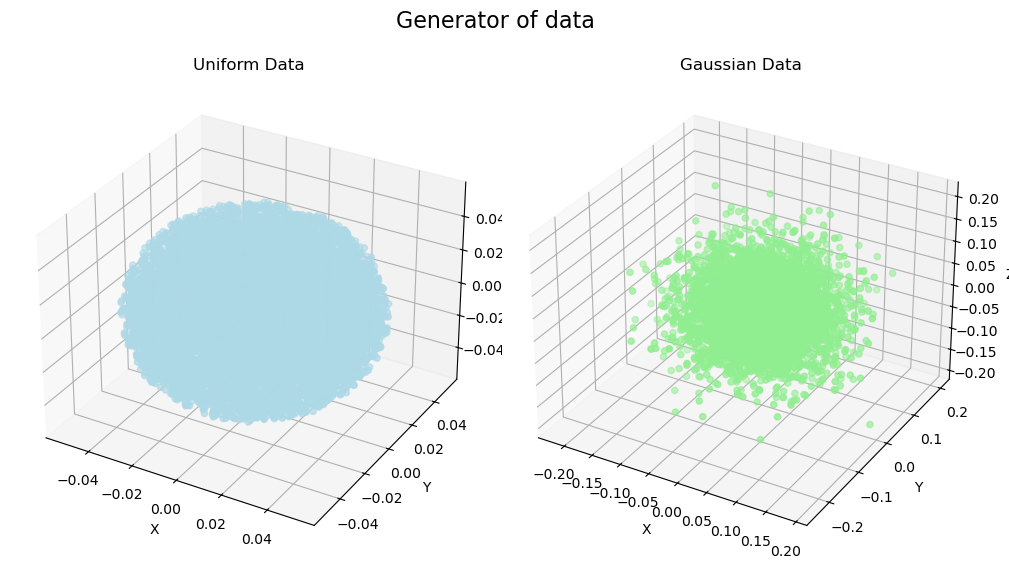

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# From spheritch to  cartesian coordinates
def spher_to_cart(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z


data_u = np.genfromtxt('./Esercizio_5_1_new/OUTPUT/unif_coordinate_generation_xyz.dat', skip_header=2, usecols=(0, 1, 2))
data_g = np.genfromtxt('./Esercizio_5_1_new/OUTPUT/gauss_coordinate_generation_xyz.dat', skip_header=2, usecols=(0, 1, 2))


x_u = data_u[:10000, 0]
y_u = data_u[:10000, 1]
z_u = data_u[:10000, 2]


x_g = data_g[:10000, 0]
y_g = data_g[:10000, 1]
z_g = data_g[:10000, 2]


fig = plt.figure(figsize=(10, 6))

fig.suptitle("Generator of data",fontsize =16)

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_u, y_u, z_u, c='lightblue', marker='o')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Uniform Data')


ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x_g, y_g, z_g, c='lightgreen', marker='o')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Gaussian Data')


plt.subplots_adjust(wspace=1)  


plt.tight_layout()
plt.show()


### Wavefunction:

In the code I created a virtual class `wavefunction.h` where I implemented the wavefuntction  $\Psi_{1,0,0}(x,y,z)$ and $\Psi_{2,1,0}(x,y,z)$. The choice to use a virtual class is usefull in order to add if necessary other wavefunction.

## Metropolis Algorithm:
The Metropolis algorithm, \( M(RT)^2 \), is a sampling method that involves rejection techniques and Markov stochastic processes:

- The first aspect refers to the rejection technique, as it explicitly proposes a tentative value that may be rejected, and because the normalization of the sampled function is irrelevant.
- The second aspect involves the Markov process, as the sampling of a particular probability density is achieved by constructing a related Markov process and simulating it.

This method is studied for its analogy with the behavior of systems in statistical mechanics that approach an equilibrium, where the statistical properties become independent of the system's kinetics. By kinetics, we mean a stochastic transfer matrix T($\vec{y}$|$\vec{x}$)  that governs the system's evolution.

\( M(RT)^2 \)'s task is to find a suitable and accurate kinetics (stochastic dynamics) that will equilibrate the system such that the given  $\rho$(x)  represents the probability of observing the system near x.

Despite its simplicity, the Metropolis algorithm has some disadvantages, such as the asymptotic nature of its correct convergence and that successive variables produced are correlated, often very strongly

### how Metropolis works:
Starting from the current position, a transition from a three-dimensional vector  $\vec y$  to a three-dimensional state $\vec x$  is proposed randomly according to either a uniform distribution with a fixed step size  $\sigma$  or a Gaussian distribution centered at 0 with standard deviation  $\sigma$ . The new point is generated by adding a random displacement vector of this length to the current position, so the displacement  $\delta$  can be less than or equal to  $\sigma$ .

The acceptance probability of the proposed move is then calculated using the Metropolis acceptance rule:

$$
A(x|y) = \min \left\{1, \frac{T(y|x) \rho(x)}{T(x|y) \rho(y)} \right\}
$$

Since symmetric distributions are used, the acceptance probability simplifies to:

$$
A(x|y) = \min \left\{1, \frac{\rho(x)}{\rho(y)} \right\}
$$

where  $\rho$($\cdot$,t) = |$\psi$($\cdot$,t)|^2 , representing the probability distribution of the electron's position. The Metropolis acceptance rule dictates that the proposed move  $\vec x$ is accepted with probability 1 if the probability of finding the electron at $\vec x$   is greater than or equal to the probability of finding it at the current position  $\vec y$, i.e., if $ p(x) \geq  p(y) $. Otherwise, the move is accepted with probability  $\frac{p(\vec x)}{p(\vec y)}$. This last step is checked against a uniformly generated random number between 0 and 1.

In the code, I created a virtual class called `metropolis.h`, where I implemented this method. The virtual class serves as a foundation for creating different subclasses, each allowing for the selection of a different distribution.

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
void metropolis_unif::metropolis_method(Waves_function* WF, vec coordinates){

    [...code to controll input... ]

    // Propose new coordinates using uniform random distribution
    vec coordinate_proposed = RND.random_newcoord_unif(get_coord_old(), unif_sigma);
    
    // Calculate wave function values at current and proposed coordinates
    double x = WF->measure(get_coord_old());
    double y = WF->measure(coordinate_proposed);
    double z = RND.Rannyu(0, 1); // Generate a uniform random number in [0,1]

    // Metropolis acceptance criteria
    if (pow(y / x, 2) >= 1.) {
        set_coord_new(coordinate_proposed); // Accept new coordinates
    }
    if (pow(y / x, 2) < 1. && z > pow(y / x, 2)) {
        set_coord_new(get_coord_old()); // Keep old coordinates
    }
    if (pow(y / x, 2) < 1. && z <= pow(y / x, 2)) {
        set_coord_new(coordinate_proposed); // Accept new coordinates
    }
    }
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\











<span style="color:red">Show a picture of your estimations of $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$</span> and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^6$) as a function of the number of blocks, $N$</font>.

- Use Bohr radius units, $a_0 = 1$ for distances:

  Ground state $1s$
  
  $$
\Psi_{1,0,0}(r,\theta,\phi)=
\frac{a_0^{-3/2}}{\sqrt{\pi}} e^{-r/a_0} 
$$
whereas one of the three $2p$ excited state is:
$$
\Psi_{2,1,0}(r,\theta,\phi)=
\frac{a_0^{-5/2}}{8}\sqrt{\frac{2}{\pi}} r e^{-r/2a_0} \cos(\theta)
$$
<span style="color:blue">Expectation values for the radius turns out to be exactly:
$$
\left\langle r \right\rangle_{\Psi_{1,0,0}} = \frac{3}{2}a_0
\quad
\left\langle r \right\rangle_{\Psi_{2,1,0}} = 5 a_0
$$
</span>



- Choose the step of the uniform transition probability $T(\vec{x}|\vec{y})$ in order to obtain 50% of acceptance in both cases

You can use a Python code similar to the following one to observe how the sampled points distribute into the 3D space:

### Rule of 50%
In order to avoid correlation between samples, it is crucial to appropriately choose the value of $\sigma$ which is a parameter that for the uniform distribution defines the interval of uniform generation for new porposed coordinate $[-\sigma,\sigma]$, while for gaussian represents the deviation standard of the distribution

If $\sigma$ is too small, the samples will be highly correlated; on the other hand, if it is too large, it becomes difficult to achieve convergence due to low acceptance efficiency. For this reason, it is necessary to tune $\sigma$ such that the acceptance rate is around 50\%.

For these reasons, the `metropolis` class includes a method called `initialize_acceptance`, in which the code preliminarily runs the Metropolis algorithm with a fixed `sigma` and calculates the acceptance rate over a set of cycles. If the acceptance rate is too high, `sigma` is increased to decrease the likelihood of proposing moves with a high acceptance probability. Conversely, if the acceptance rate is too low, `sigma` is decreased to make the sampling more precise and ensure a more appropriate acceptance rate.

(NB. `metropolis_unif`is the derived class of the virtual class `metropolis` in which it is used the uniform distribution, but there is the same for the gaussian one called  `metropolis_gauss`).

    void metropolis_unif::initialize_acceptance(Waves_function* WF, vec coordinates, int wf) {
    double counter = 0.;
    ofstream out_acc;
    
    out_acc.open("./OUTPUT/accettanza_unif_"+to_string(wf)+"_.dat");
    bool repeat = false;
    vec coordinates_true = coordinates;
    int step = 100000;
    double s = get_sigma(); // initial sigma
    double target_acceptance = 0.5; // Target of acceptance
    double tolerance = 0.0001; // Tollerance for acceptance

    do {
        counter = 0; //reinitialize the cycle
        vec x = get_coord_old();  \\position stored
            x.print("x primario ");
    
        for (int i = 0; i < step; i++) {
            vec x = get_coord_old();
            metropolis_method(WF, x);
            vec y = get_coord_old();
            // comparison between vectors, if x and y are the same means that the moving proposed is not accepted
            if (!arma::all(x == y)) {
                counter += 1;
            }
        }

        double acceptance_rate = counter / (double) step;
        //cout << "sigma: "<< get_sigma() << " " <<" accettanza del ciclo: " << acceptance_rate*100. << endl;
        out_acc << get_sigma() << " " << acceptance_rate*100 << endl;
         if (acceptance_rate > target_acceptance + tolerance) {
        s *= 1.0 + 0.1 * (acceptance_rate - target_acceptance); // increase sigma to the excess of acceptation
        }else if (acceptance_rate < target_acceptance - tolerance) {
        s *= 1.0 - 0.1 * (target_acceptance - acceptance_rate); // Decrease sigma proportional to the deficit of acceptation
        } 
        if (acceptance_rate > target_acceptance - tolerance && acceptance_rate < target_acceptance + tolerance){
            repeat = true; // Stop if the rate is accetable
        }

        set_sigma(s); // Load the new sigma
        set_coord_new(coordinates_true);
        

        } while (repeat == false);

}

Below are showed the grapichs for the different acceptance for the the different wavefunction mapping with gaussian and uniform distribution.
And it is found the following result (in unit of atom bohr ray $a_0$)
- $\sigma_{unif_{100}} = 1.566$
- $\sigma_{unif_{210}} = 3.809$
- $\sigma_{gauss_{100}} = 0.759$
- $\sigma_{gauss_{210}} = 1.874$





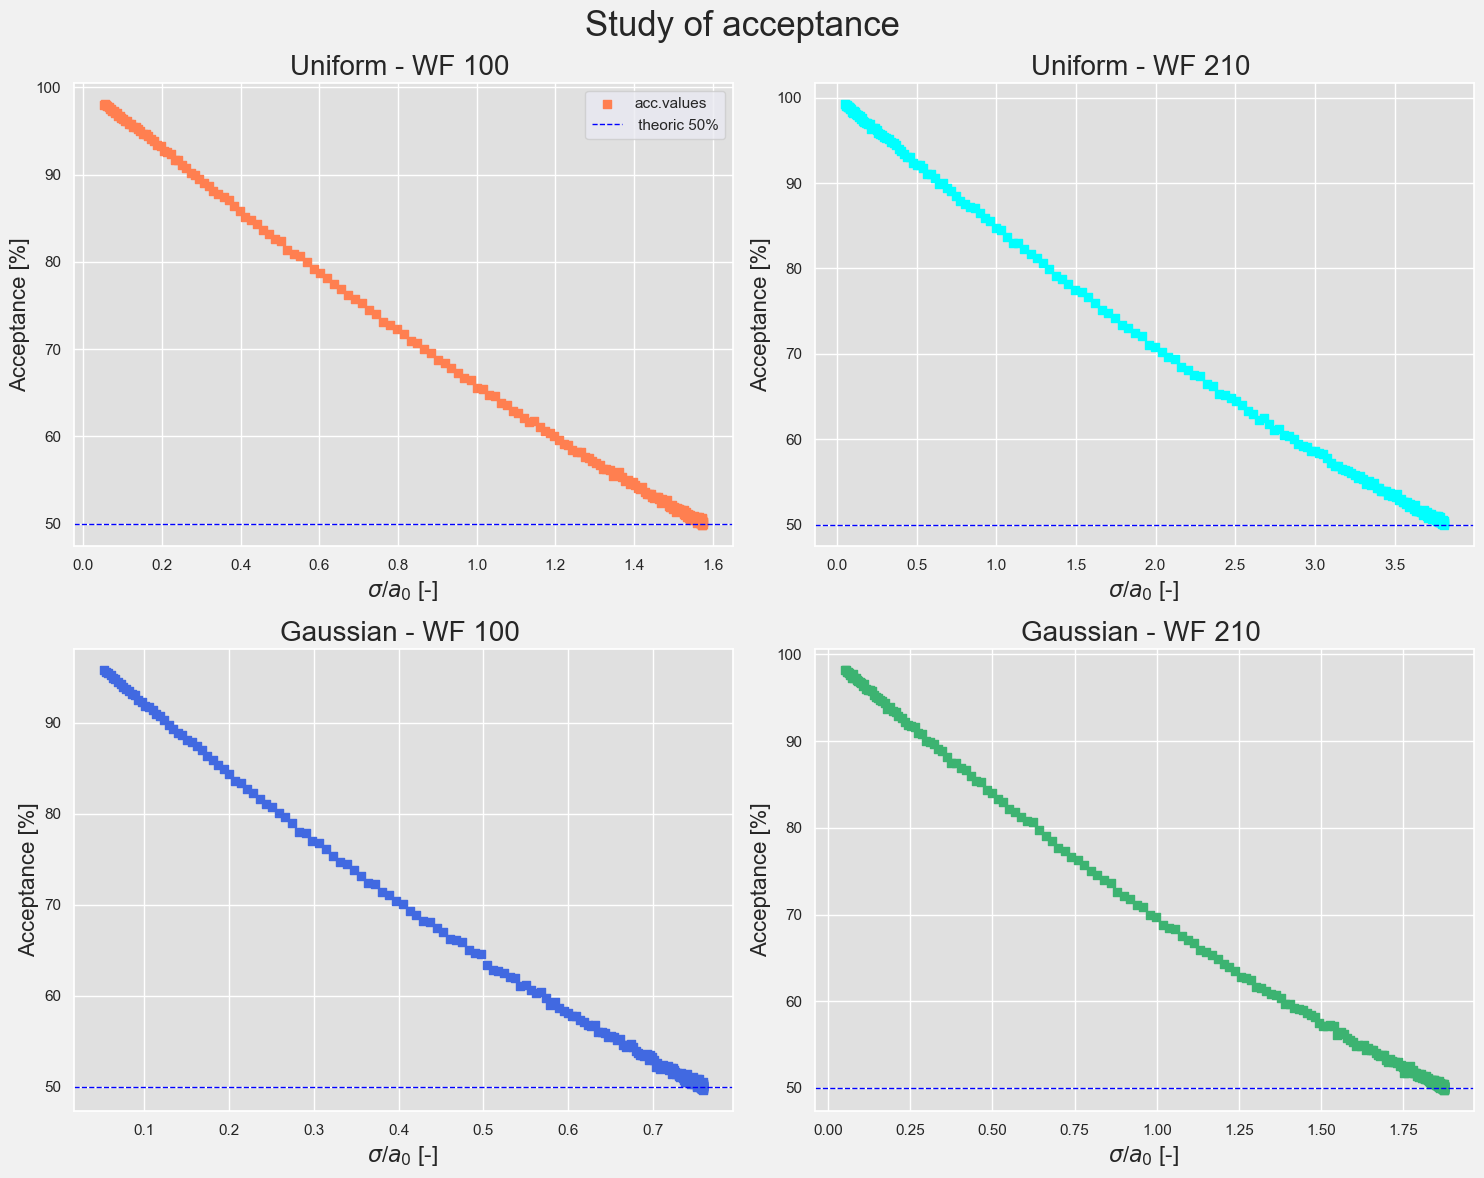

In [51]:
import numpy as np
import matplotlib.pyplot as plt


# Carica i dati dal file, saltando le righe non numeriche
data_gauss_100 = np.genfromtxt('./Esercizio_5_1_new/OUTPUT/accettanza_gauss_100_.dat', 
                               skip_header=2, 
                               usecols=(0, 1))

data_unif_100 = np.genfromtxt('./Esercizio_5_1_new/OUTPUT/accettanza_unif_100_.dat', 
                               skip_header=2, 
                               usecols=(0, 1))

data_gauss_210 = np.genfromtxt('./Esercizio_5_1_new/OUTPUT/accettanza_gauss_210_.dat', 
                               skip_header=2, 
                               usecols=(0, 1))

data_unif_210 = np.genfromtxt('./Esercizio_5_1_new/OUTPUT/accettanza_unif_210_.dat', 
                               skip_header=2, 
                               usecols=(0, 1))


sigma_g_100 = data_gauss_100[:, 0]
accettanza_g_100 = data_gauss_100[:, 1]

sigma_u_100 = data_unif_100[:, 0]
accettanza_u_100 = data_unif_100[:, 1]

sigma_g_210 = data_gauss_210[:, 0]
accettanza_g_210 = data_gauss_210[:, 1]

sigma_u_210 = data_unif_210[:, 0]
accettanza_u_210 = data_unif_210[:, 1]


fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.patch.set_facecolor('#f1f1f1')  


  
fig.suptitle("Study of acceptance", fontsize = 25)

#  Uniform w100
axs[0, 0].set_facecolor('#e0e0e0')  
axs[0, 0].scatter(sigma_u_100, accettanza_u_100, c='coral', marker='s',label = 'acc.values' )
axs[0, 0].axhline(y=50, color='blue', linestyle='--', linewidth=1,label = ' theoric 50%')
axs[0, 0].set_xlabel(r'$\sigma$/$a_{0}$ [-] ',fontsize =16)
axs[0, 0].set_ylabel('Acceptance [%]',fontsize =16)
axs[0, 0].set_title('Uniform - WF 100 ',fontsize =20)
axs[0, 0].grid(True)
axs[0, 0].legend()

#  Uniform w210
axs[0, 1].set_facecolor('#e0e0e0')  
axs[0, 1].scatter(sigma_u_210, accettanza_u_210, c='cyan', marker='s',label = 'acc.values')
axs[0, 1].axhline(y=50, color='blue', linestyle='--', linewidth=1,label = ' theoric 50%')
axs[0, 1].set_xlabel(r'$\sigma$/$a_{0}$ [-] ',fontsize =16)
axs[0, 1].set_ylabel('Acceptance [%]',fontsize =16)
axs[0, 1].set_title('Uniform - WF 210 ',fontsize =20)
axs[0, 1].grid(True)

# Gauss w100
axs[1, 0].set_facecolor('#e0e0e0')  
axs[1, 0].scatter(sigma_g_100, accettanza_g_100, c='royalblue', marker='s',label = 'acc.values')
axs[1, 0].axhline(y=50, color='blue', linestyle='--', linewidth=1,label = ' theoric 50%')
axs[1, 0].set_xlabel(r'$\sigma$/$a_{0}$ [-] ',fontsize =16)
axs[1, 0].set_ylabel('Acceptance [%]',fontsize =16)
axs[1, 0].set_title('Gaussian - WF 100 ',fontsize =20)
axs[1, 0].grid(True)

# Quarto grafico: Gauss w210
axs[1, 1].set_facecolor('#e0e0e0')  
axs[1, 1].scatter(sigma_g_210, accettanza_g_210, c='mediumseagreen', marker='s',label = 'acc.values')
axs[1, 1].axhline(y=50, color='blue', linestyle='--', linewidth=1,label = ' theoric 50%')
axs[1, 1].set_xlabel(r'$\sigma$/$a_{0}$ [-] ',fontsize =16)
axs[1, 1].set_ylabel('Acceptance [%]',fontsize =16)
axs[1, 1].set_title('Gaussian - WF 210 ',fontsize =20)
axs[1, 1].grid(True)




plt.tight_layout()
plt.show()


Here it is possible to observe how the programm changes $\sigma$ for different method exausted the rule of 50%.

- Choose a reasonable starting point in the 3D space and equilibrate your sampling before to start measuring the radius. What do you observe when you start very far from the origin?

### Equilibration and different starting point

Before running the simulation, it is essential to equilibrate the system to ensure that measurements are not taken while the particle is still in positions that could affect the estimation of the average distance from the center.

For the equilibration phase, I chose the origin as the starting point for both states. To demonstrate that, starting from any initial point, there exists an equilibration time such that the system converges to the solution, I also equilibrated the system starting from different initial configurations.

For this reason, before applying the data blocking method (in the main, there is a function called `Bloch_mean_method` that performs it), I performed the equilibration simulating $10^5$ steps.

Below there are plot different results, starting the simulation from different position, in the case for generate new coordinate from uniform distribution for WF 100:


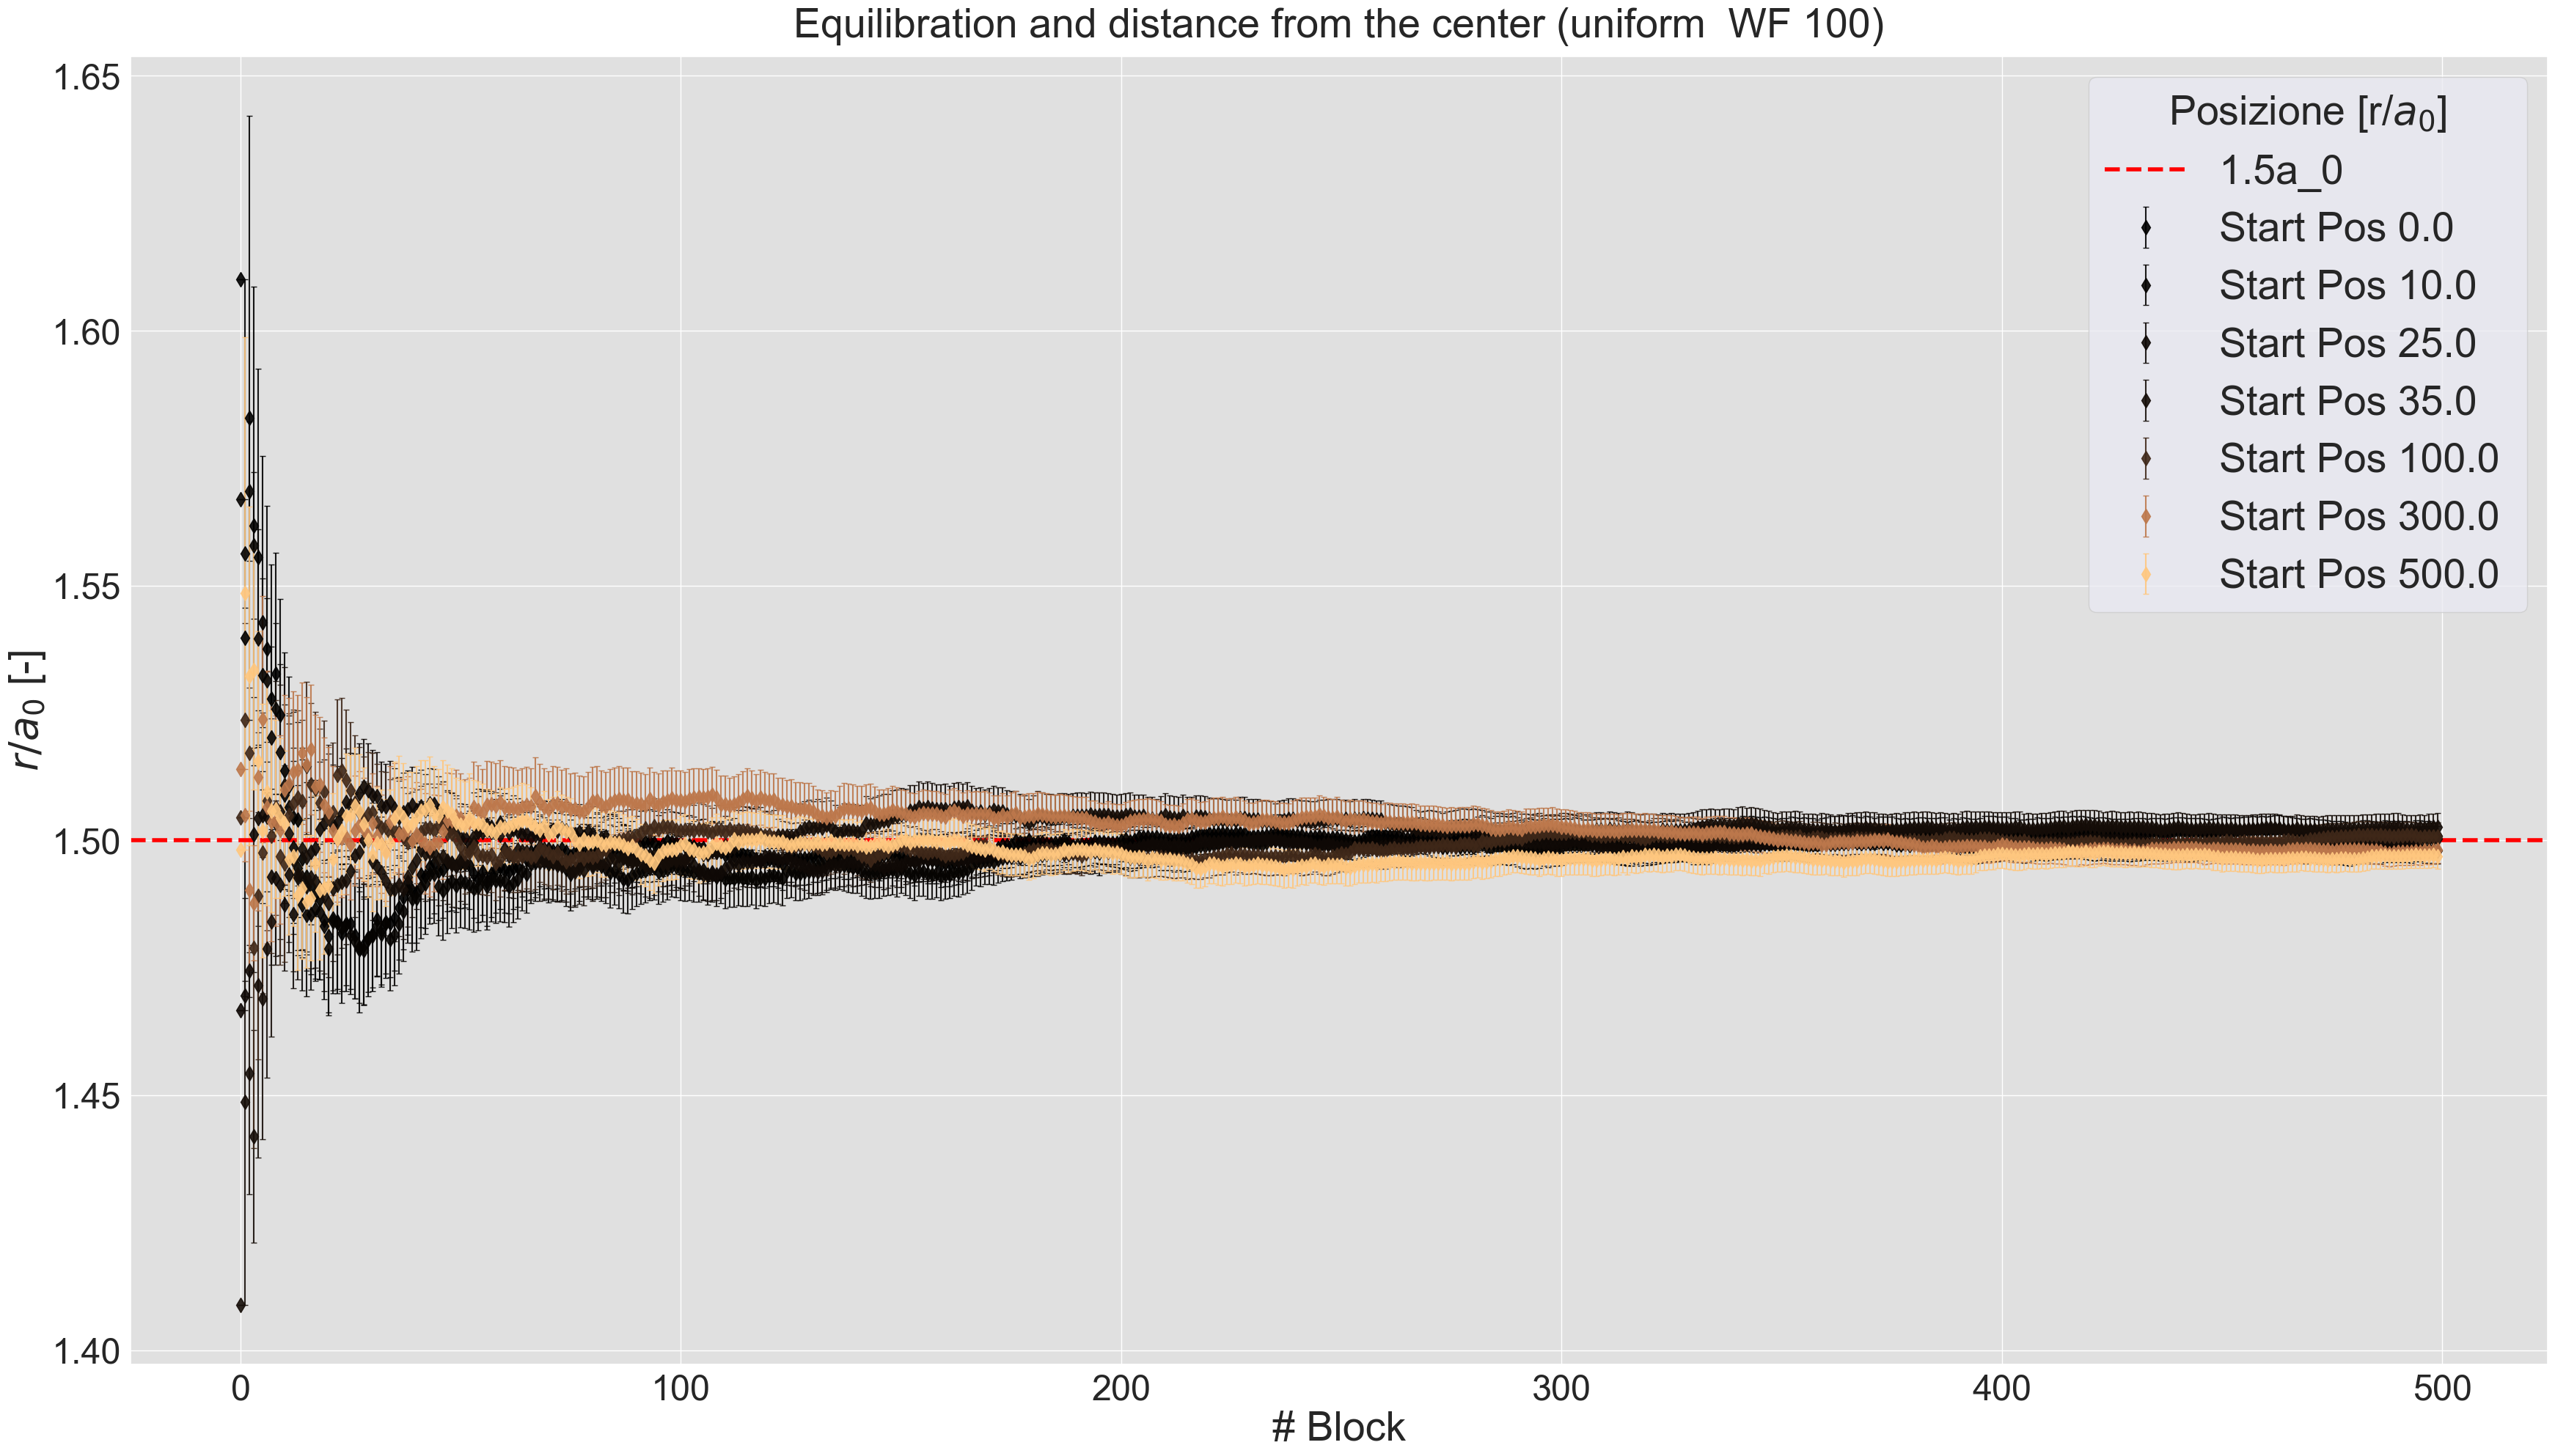

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

base_path = './Esercizio_5_1_new/OUTPUT/raggio_unif_w100_pos_{}_0.0_0.0_5000_step.dat'
positions = [0.0, 10.0, 25.0, 35.0, 100.0, 300.0, 500.0]


fig, ax = plt.subplots(figsize=(35, 20))


ax.set_facecolor('#e0e0e0') 


norm = mcolors.Normalize(vmin=min(positions), vmax=max(positions))
cmap = plt.cm.copper  


for pos in positions:
    
    file_path = base_path.format(pos)
    
    try:
        
        data = np.loadtxt(file_path)
        
        
        x = np.arange(500)
        
        
        y = data[:, 0]  
        yerr = data[:, 1]  
        
        
        color = cmap(norm(pos))
        
      
        ax.errorbar(x, y, yerr=yerr, label=f'Start Pos {pos} ', fmt='d', color=color, capsize=3 ,linestyle=' ',alpha =0.9, markersize =10)
    
    except OSError:
        print(f"File non trovato: {file_path}")


ax.axhline(y=1.5, color='red', linestyle='--', linewidth=4, label='1.5a_0')
ax.set_xlabel('# Block', fontsize=40)
ax.set_ylabel(r'$r/a_{0}$ [-]', fontsize=40)
ax.set_title('Equilibration and distance from the center (uniform  WF 100)', fontsize=40, y = 1.01)
ax.legend(title=r'Posizione [r/$a_{0}$]', fontsize=40, title_fontsize= 40)
ax.grid(True)
ax.tick_params(axis='both', labelsize=35)


plt.tight_layout()
plt.show()


What can be inferred from this graph is that, for the starting distances, the system is able to reach the convergence point.


- How large should be the number of Monte Carlo Metropolis steps in each block?
In order to see how much step is needed inside each block, I calculate the curve for different number of step, initializing system at origin as starting point. It is possible to note that much are the step inside bloch much is precised measured.
In addition, the equilibration, for the gran part of measure, need generally 200 block for WF100 and 250 for WF210. After that the system converge to the data attended. $$\left\langle r \right\rangle_{\Psi_{1,0,0}} = \frac{3}{2}a_0
\quad
\left\langle r \right\rangle_{\Psi_{2,1,0}} = 5 a_0
$$

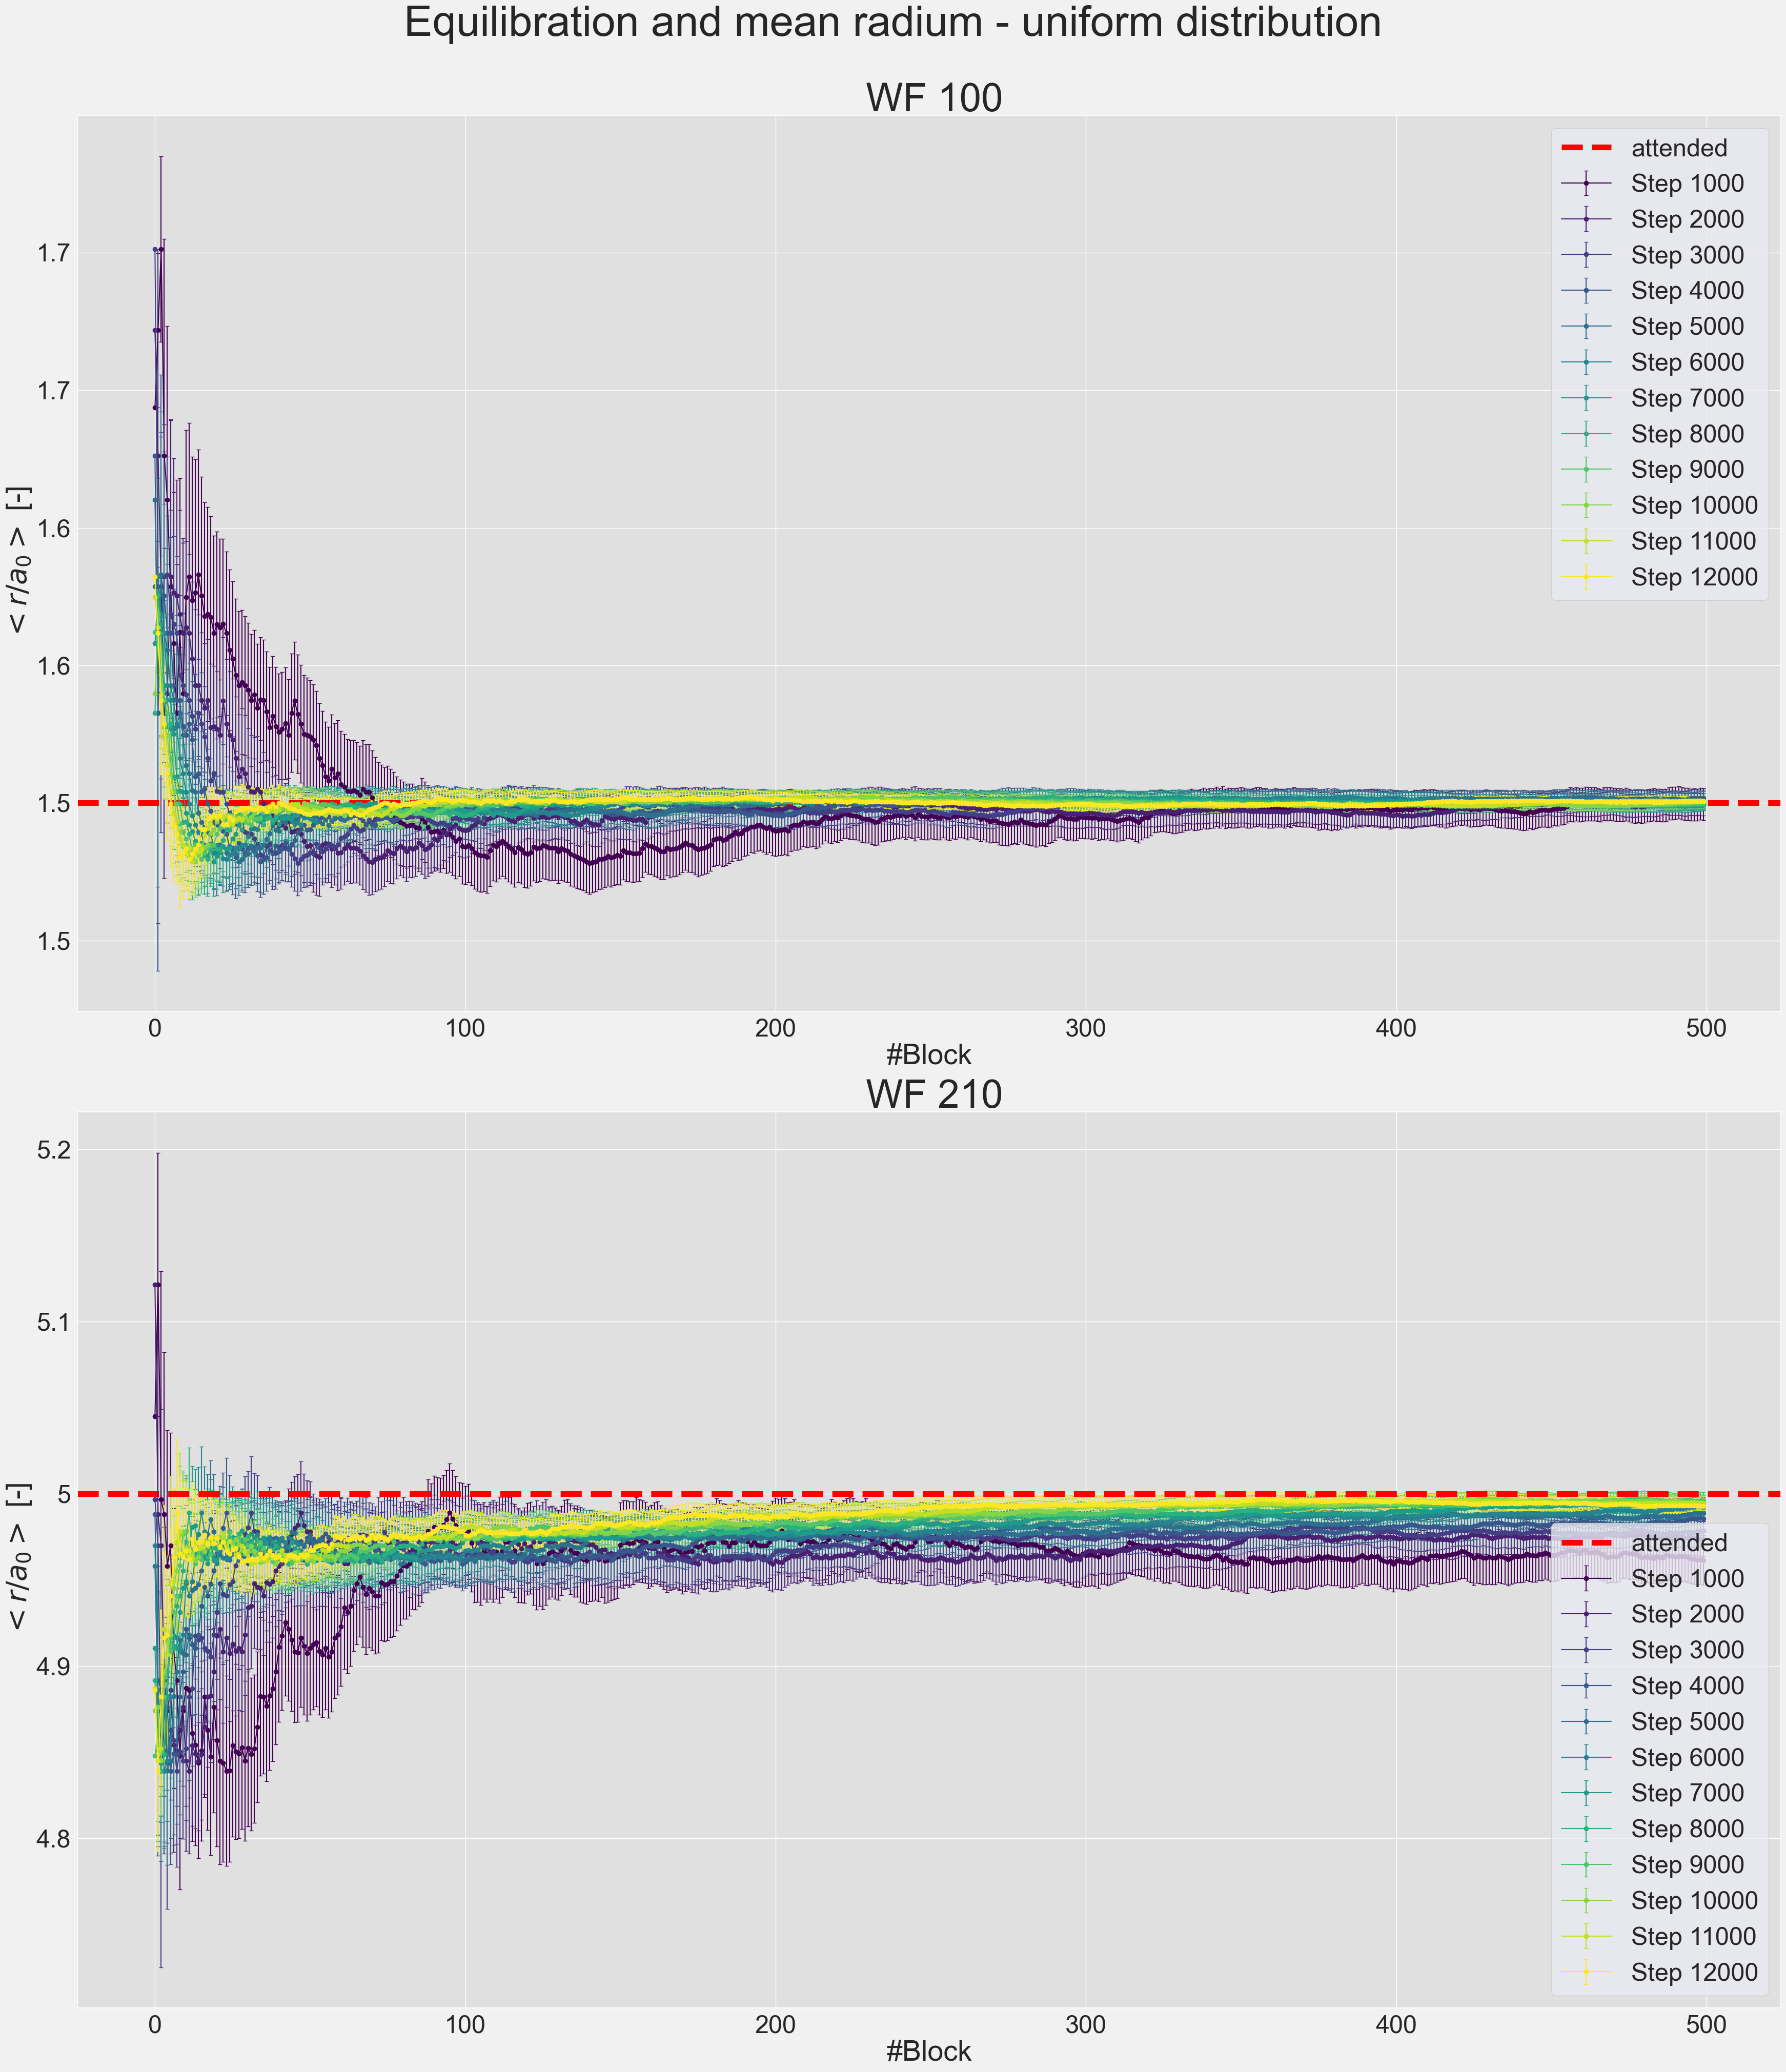

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker


prefixes = ['Esercizio_5_1_new/OUTPUT/raggio_unif_w100', 'Esercizio_5_1_new/OUTPUT/raggio_unif_w210']
steps = range(1000, 13000, 1000)  # Step da 1000 a 12000

# Creazione dei subplot
fig, axs = plt.subplots(2, 1, figsize=(35, 40))  # Due subplot in una sola riga


fig.patch.set_facecolor('#f1f1f1')  
fig.suptitle(r'Equilibration and mean radium - uniform distribution', fontsize=60, y=1.01)


norm = mcolors.Normalize(vmin=min(steps), vmax=max(steps))
cmap = plt.colormaps['viridis']  # Colormap 'viridis'


for idx, prefix in enumerate(prefixes):
    ax = axs[idx] 
    

    ax.set_facecolor('#e0e0e0')  
    
    
    for step in steps:
        filename = f'{prefix}_pos_0.0_0.0_0.0_{step}_step.dat'
        
        try:
            # Carico i dati dal file
            data = np.loadtxt(filename)
            
           
            x = np.arange(0, 500)
            

            y = data[:, 0]  
            yerr = data[:, 1]  
            
            
            color = cmap(norm(step))

            
            ax.errorbar(x, y, yerr=yerr, label=f'Step {step}', fmt='-o', color=color, capsize=3 )

        except OSError:
            print(f"File non trovato: {filename}")
    
    # extration of prefix for the title
    tipo = prefix.split('_')[4]  # 
    wf = prefix.split('_')[5]    # 'w100' o 'w210'
    title = f' WF {wf[1:]}'  # 'gauss wf 100' o 'unif wf 210'
    
    ax.set_title(title, fontsize=55)  # Imposta il titolo dinamico
    
    
    if wf == 'w100':
        ax.axhline(y=1.50, color='red', linestyle='--', label='attended', lw=8)  
        #ax.axvline(x=200, color='blue', linestyle='--', label='equilibration', lw=5)
    elif wf == 'w210':
        ax.axhline(y=5.00, color='red', linestyle='--', label='attended', lw=8)  
        #ax.axvline(x=250, color='blue', linestyle='--', label='equilibration', lw=5)

    # legend and feature
    ax.grid(True)
    ax.set_xlabel("#Block", fontsize=40)  
    ax.set_ylabel(r'$<r/a_{0}>$ [-]', fontsize=40)  
    ax.tick_params(axis='both', labelsize=35)
    ax.legend(fontsize = 35)

   
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.2g}'))
    


plt.tight_layout()
plt.show()


For all steps, the system reaches convergence to the expected value for WF 100, while for WF 210, convergence is not reached for all steps. It is only achieved after a threshold of 8000 steps. It may be necessary to increase the number of blocks for those starting with fewer steps."

- <span style="color:red">If you use a multivariate normal transition probability $T(\vec{x}|\vec{y})$, i.e. a Gaussian for each coordinate, your results for $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$ are equivalent?</span>

Doing the same operation for a normal distribution is seen that it is possible to reach the same results, even though it is necessary a greater number of blocks for equilibration

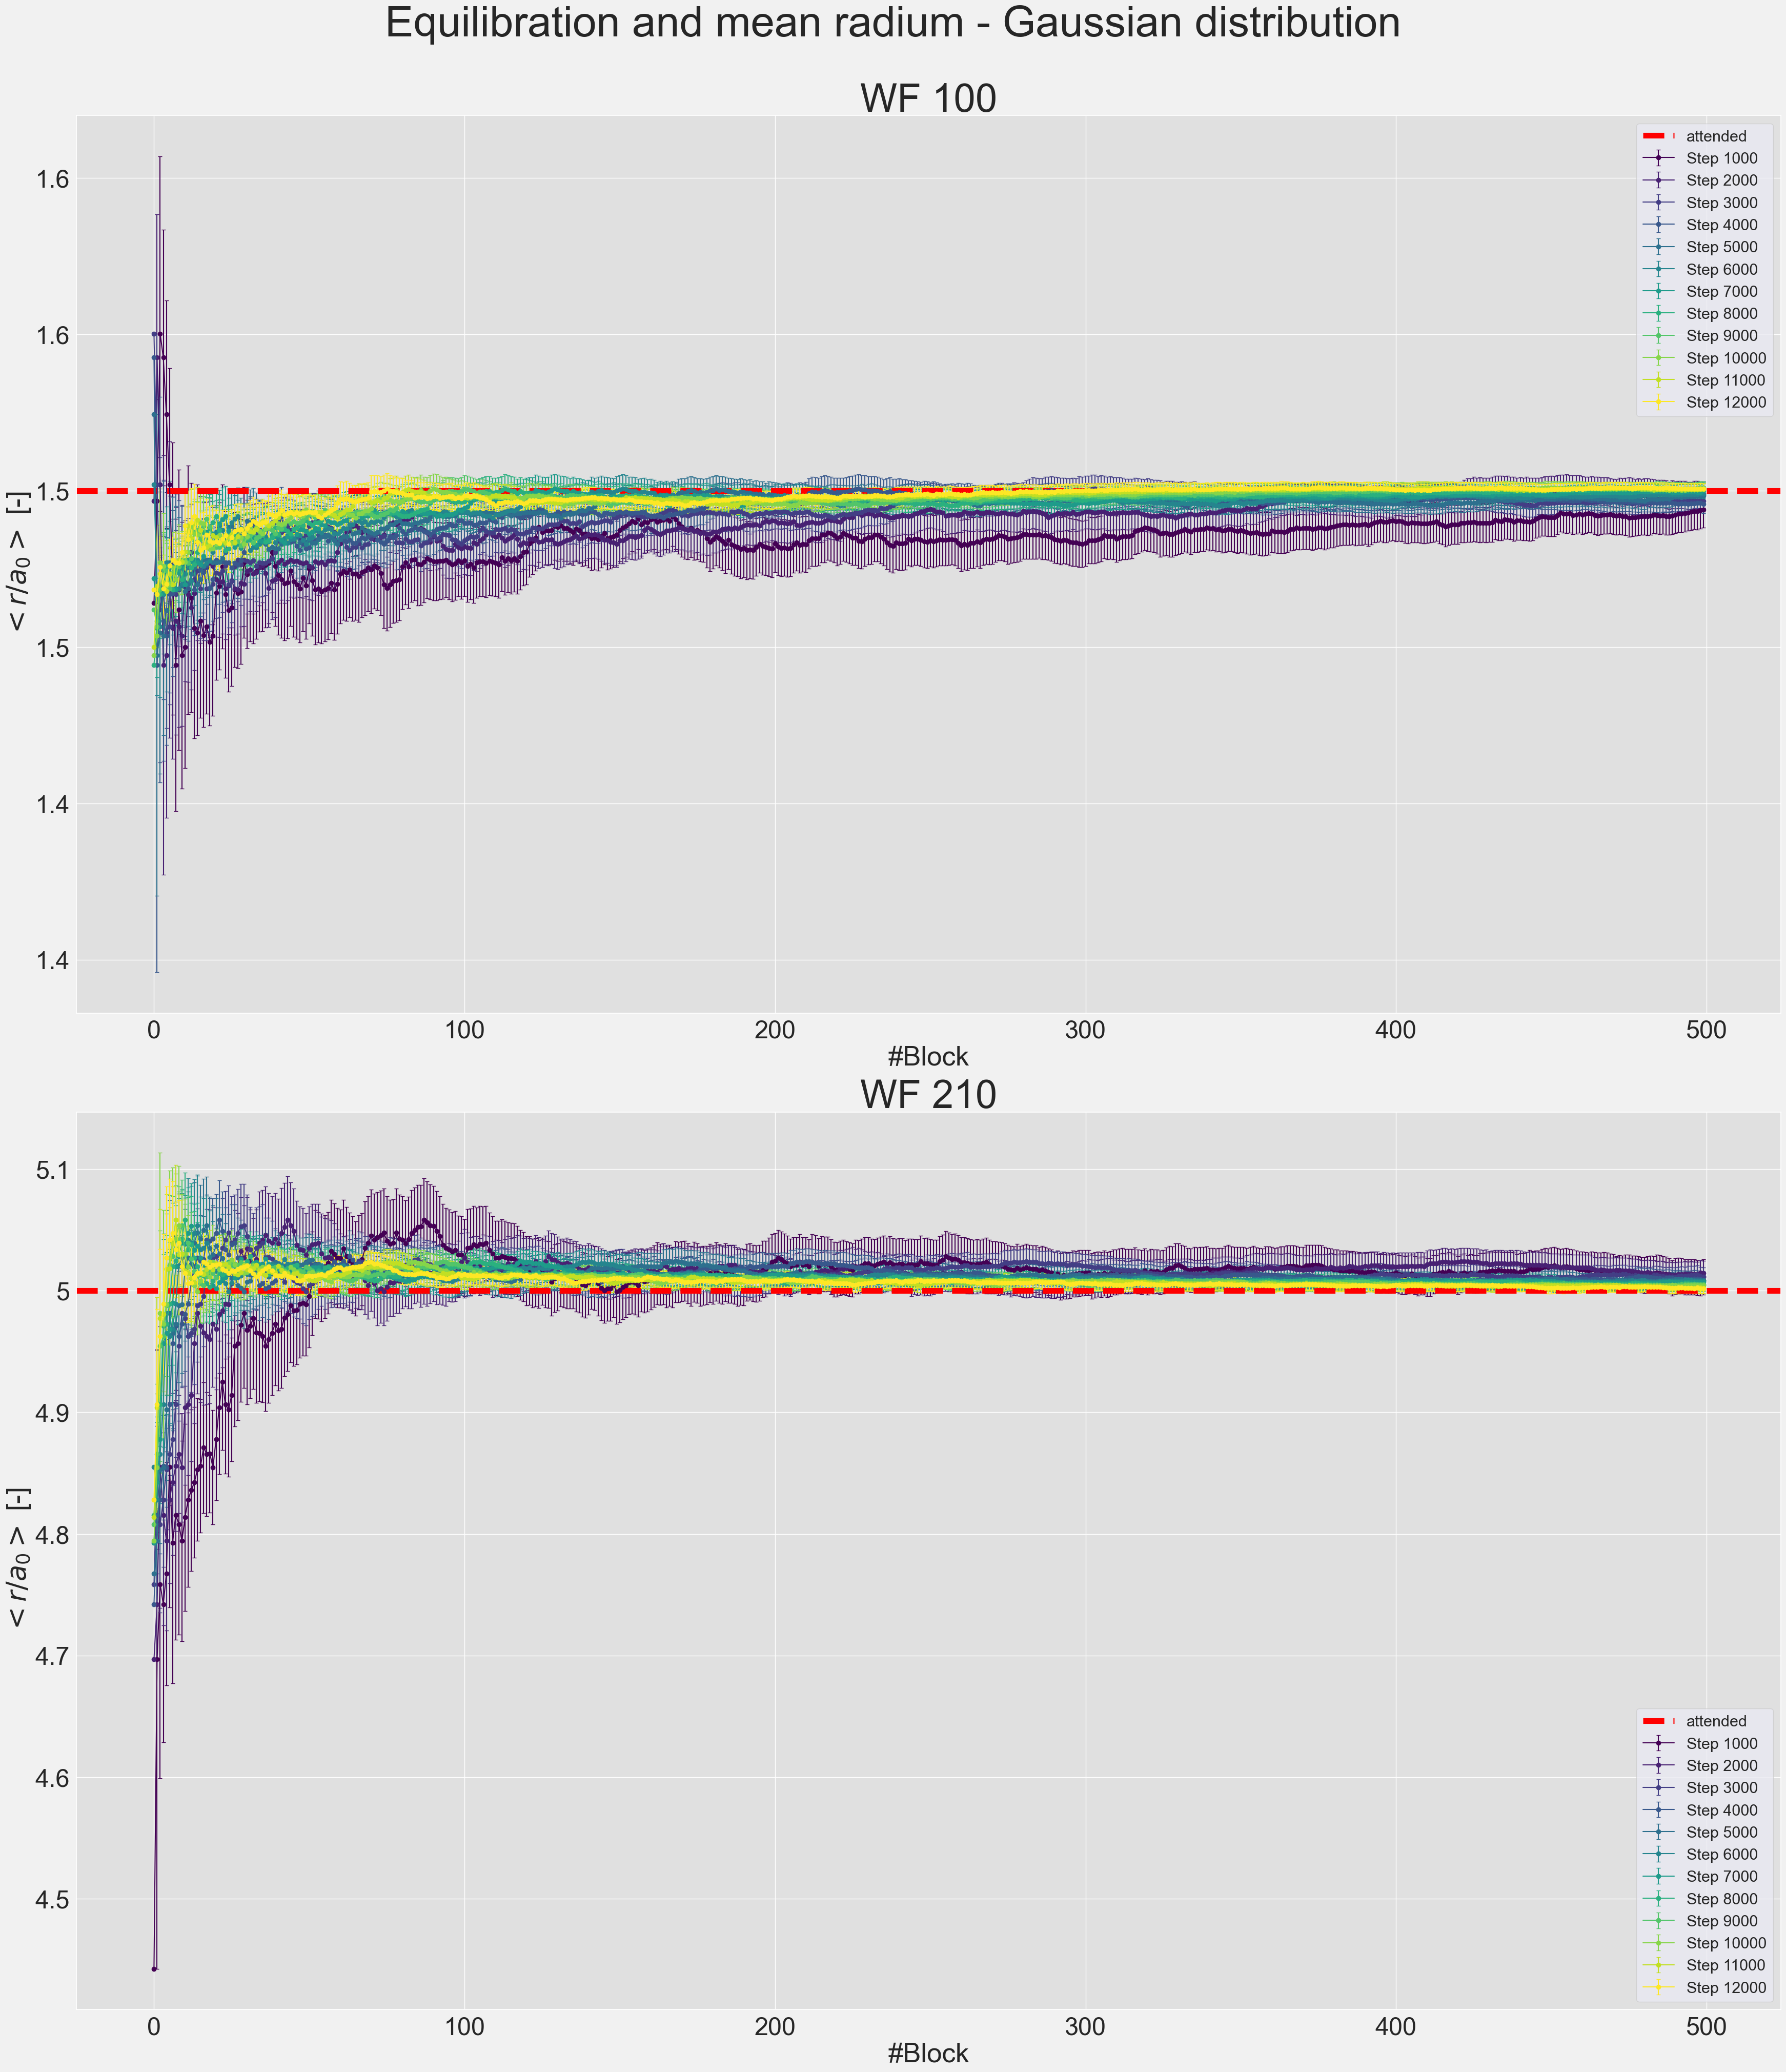

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

# Defining variable parameters
prefixes = ['Esercizio_5_1_new/OUTPUT/raggio_gauss_w100', 'Esercizio_5_1_new/OUTPUT/raggio_gauss_w210']
steps = range(1000, 13000, 1000)  # Steps from 1000 to 12000

# Create subplots (2 rows, 1 column)
fig, axs = plt.subplots(2, 1, figsize=(35,40))  # Two subplots in a single column

# Change background color of the figure
fig.patch.set_facecolor('#f1f1f1')  
fig.suptitle(r'Equilibration and mean radium - Gaussian distribution', fontsize=60, y=1.01)

# Normalizer for colormap, based on the steps
norm = mcolors.Normalize(vmin=min(steps), vmax=max(steps))
cmap = plt.colormaps['viridis']  # 'viridis' colormap

# Loop through each prefix to create titles and read data
for idx, prefix in enumerate(prefixes):
    ax = axs[idx]  # Accessing the subplot by index
    
    # Change the background color of the plot area
    ax.set_facecolor('#e0e0e0')  # Light gray color
    
    # Loop through the steps and construct the file name
    for step in steps:
        filename = f'{prefix}_pos_0.0_0.0_0.0_{step}_step.dat'
        
        try:
            # Load the data from the file
            data = np.loadtxt(filename)
            
            # X values range from 0 to 99, corresponding to 100 blocks
            x = np.arange(0, 500)
            
            # The first column is the value, the second is the error
            y = data[:, 0]  # Y values
            yerr = data[:, 1]  # Errors associated with Y values
            
            # Get color from the colormap based on the step
            color = cmap(norm(step))

            # Plot the data with error bars, applying the colormap
            ax.errorbar(x, y, yerr=yerr, label=f'Step {step}', fmt='-o', color=color, capsize=3)

        except OSError:
            print(f"File not found: {filename}")
    
    # Extract the type and wf from the prefix to create the title
    tipo = prefix.split('_')[4]  # 'gauss' or 'unif'
    wf = prefix.split('_')[5]    # 'w100' or 'w210'
    title = f'WF {wf[1:]}'  # 'gauss wf 100' or 'unif wf 210'
    
    ax.set_title(title, fontsize=55)  # Set the dynamic title
    
    # Add horizontal lines based on the wf value
    if wf == 'w100':
        ax.axhline(y=1.50, color='red', linestyle='--', label='attended', lw=8)  # Color for wf 100
        #ax.axvline(x=200, color='blue', linestyle='--', label='equilibration end', lw=4)  # Color for wf 210
    elif wf == 'w210':
        ax.axhline(y=5.00, color='red', linestyle='--', label='attended', lw=8)  # Color for wf 210
        #ax.axvline(x=300, color='blue', linestyle='--', label='equilibration end', lw=4)  # Color for wf 210

    # Set the legend and other plot features
    ax.legend(fontsize=22)  # Change the font size of the legend
    ax.grid(True)
    ax.set_xlabel("#Block", fontsize=38)  # X-axis label
    ax.set_ylabel(r'$<r/a_{0}>$ [-]', fontsize=38)  # Y-axis label
    ax.tick_params(axis='both', labelsize=35)

    # Set Y-axis format to have two significant digits
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.2g}'))

# Clean layout and display the plot
plt.tight_layout()
plt.show()


Differently to the previous case, for all steps, the system reaches convergence to the expected value for WF 100 and WF 210.

## Wave function mapped
Finally ,below I show the grapich of the wavefunction mapped with metropolis algorithm.
In particolar in this graphics `WF 100` is sampled starting from $50 r/a_0$ in order to see the way with which sampling converge to the desired wave function; while the `WF 210`od the excited stated is mapped starting from the origin of axes where are clearly visible the regions of the excited orbital

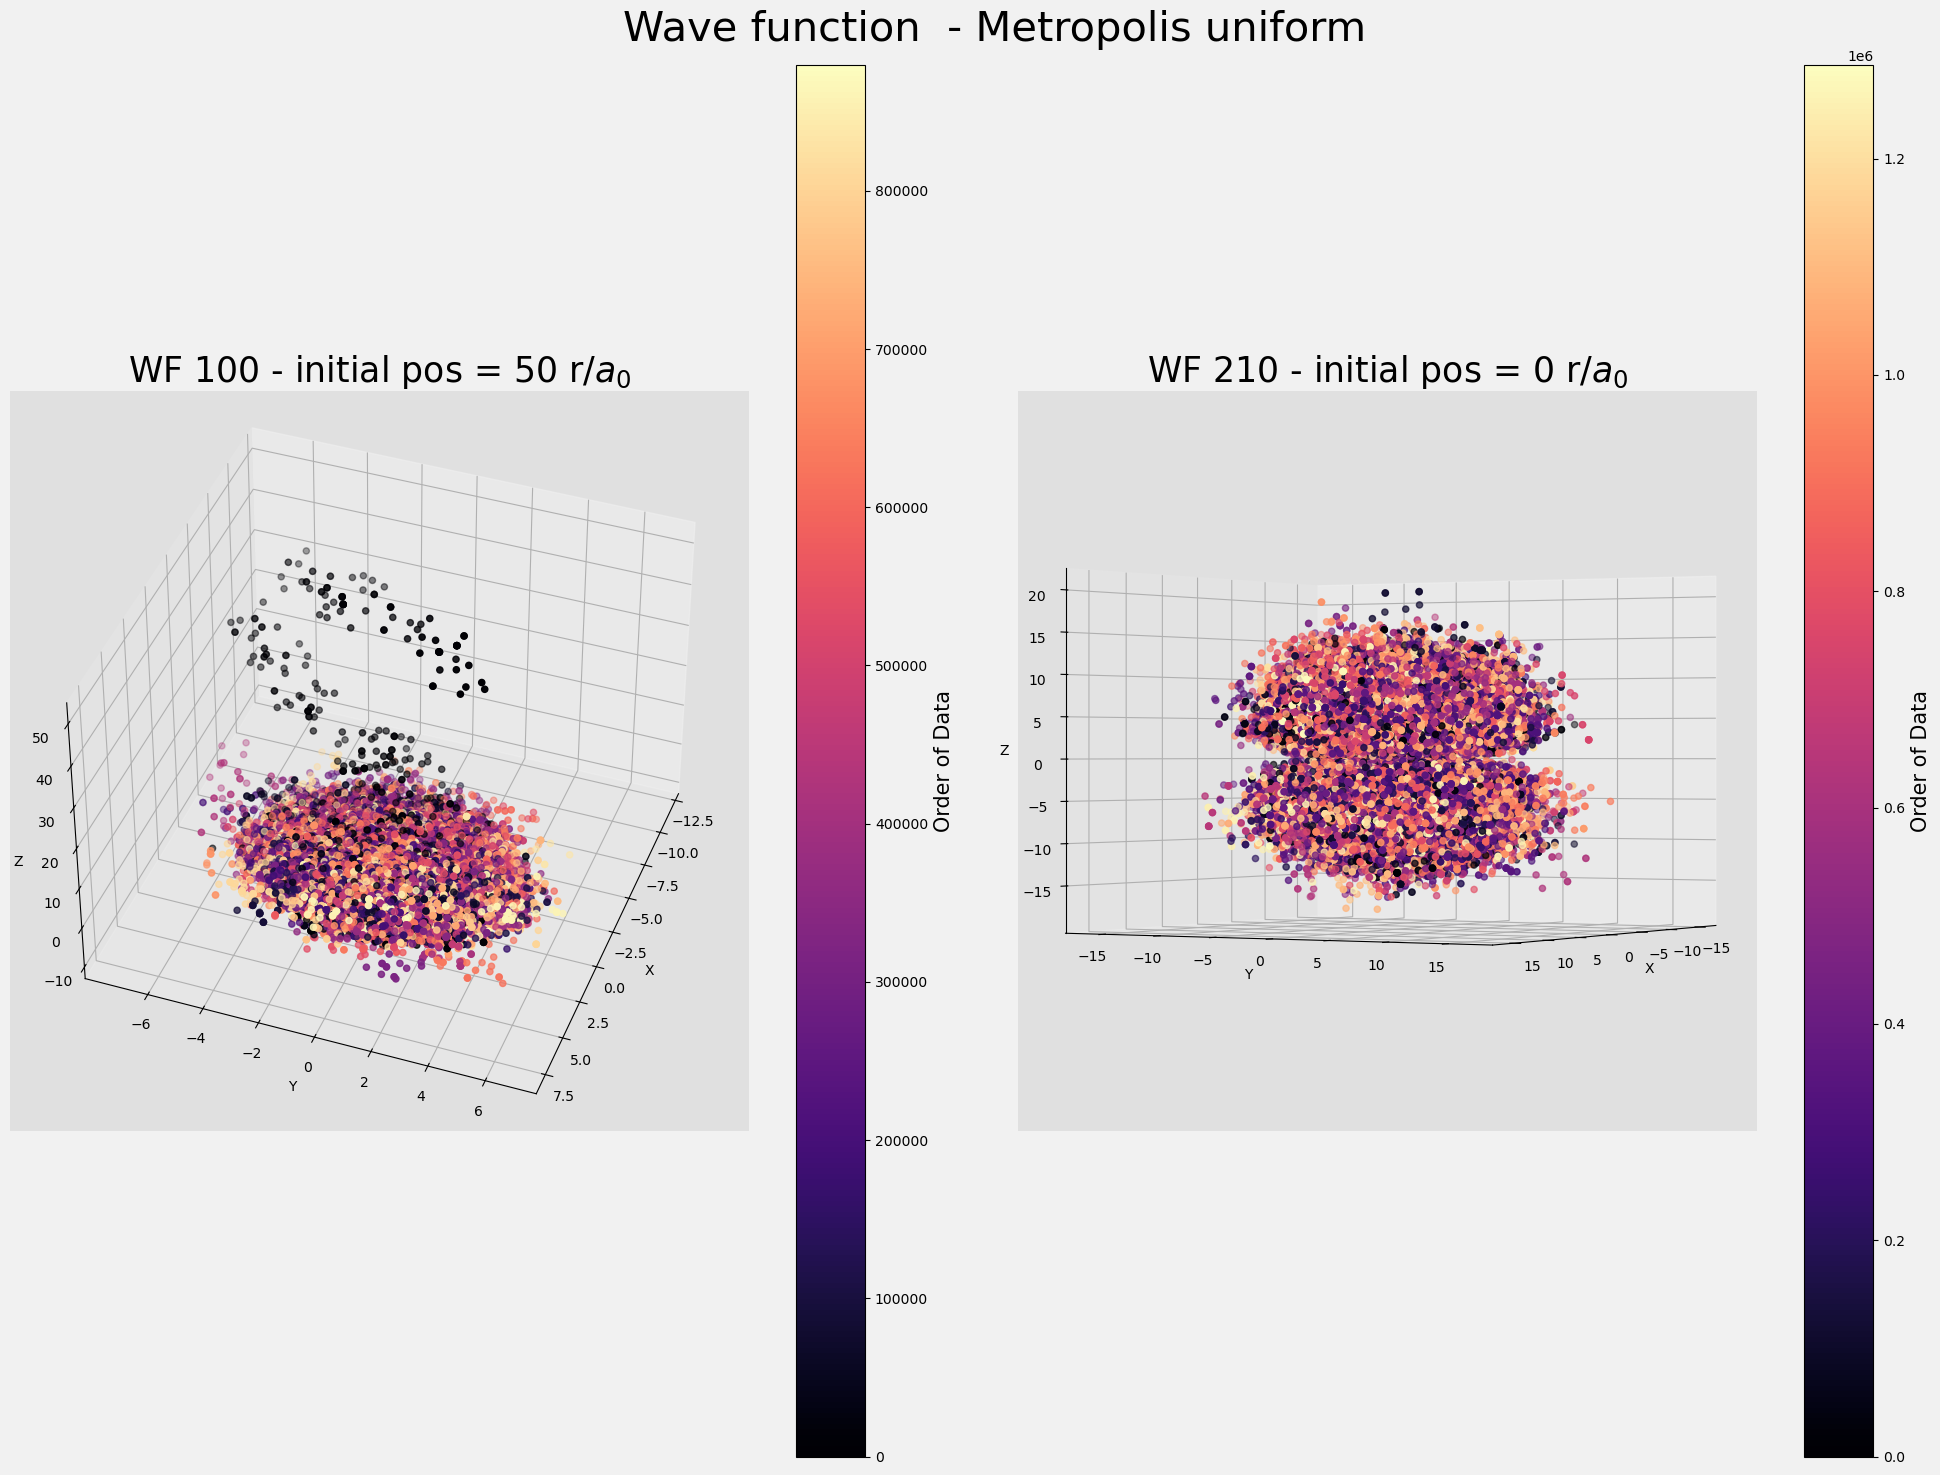

In [1]:
import numpy as np
import matplotlib.pyplot as plt


data_u = np.genfromtxt('./Esercizio_5_1_new/OUTPUT/Coordinate_accettate_uniforme_100_50.0_.dat', usecols=(0, 1, 2))
data_g = np.genfromtxt('./Esercizio_5_1_new/OUTPUT/Coordinate_accettate_uniforme_210_0.0_.dat', usecols=(0, 1, 2))


x_u = data_u[0:1000000, 0]
y_u = data_u[0:1000000, 1]
z_u = data_u[0:1000000, 2]

x_g = data_g[:, 0]
y_g = data_g[:, 1]
z_g = data_g[:, 2]

# Creazione della figura e dei subplot
fig = plt.figure(figsize=(20, 15))
fig.patch.set_facecolor('#f1f1f1')  


# First: Uniform w100
fig.suptitle("Wave function  - Metropolis uniform", fontsize=30)

# Creiamo un array per l'indice dei dati, che useremo per la colormap
indices_u = np.arange(len(x_u))
indices_g = np.arange(len(x_g))

# First subplot: dati uniformi
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(x_u, y_u, z_u, c=indices_u, cmap='magma', marker='o')
ax1.set_facecolor('#e0e0e0') 
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(r'WF 100 - initial pos = 50 r/$a_0$', fontsize =25)
ax1.view_init(elev=40, azim=20)

##colorbar
cbar1 = plt.colorbar(sc1, ax=ax1)
cbar1.set_label('Order of Data', fontsize=15)

# Second subplot: dati gaussiani
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_facecolor('#e0e0e0') 
sc2 = ax2.scatter(x_g, y_g, z_g, c=indices_g, cmap='magma', marker='o')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(r'WF 210 - initial pos = 0 r/$a_0$',fontsize =25)
ax2.view_init(elev=0, azim=30)


cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label('Order of Data', fontsize=15)

plt.subplots_adjust(wspace=1) 


plt.tight_layout()
plt.show()


In these last graphs, it can be observed how the system is able to map the wave functions of the 1s state and the excited 2p state. Specifically, for the first state, it is possible to see how the system 'moves' towards the more favorable state, while for the second, it starts constructing the wave function right from the beginning. This is due to the starting position.
